In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.layers import LSTM
from keras.models import Sequential, load_model
# from pyswarm import pso
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import CSVLogger, ReduceLROnPlateau
import numpy as np
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense, Activation, Conv1D, MaxPooling1D, Flatten, Reshape,Bidirectional,Input
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import LSTM
from keras.models import Sequential, load_model
from keras.callbacks import CSVLogger, ReduceLROnPlateau
import time  # 引入time模块

In [3]:
import warnings
warnings.filterwarnings("ignore")
np.random.seed(120)
tf.random.set_seed(120)
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
import warnings
warnings.filterwarnings("ignore")
np.random.seed(120)
tf.random.set_seed(120)
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [4]:
import numpy as np
import pandas as pd

def hav(theta):
    s = np.sin(theta / 2)
    return s * s

def get_distance_hav(lat0, lng0, lat1, lng1):
    EARTH_RADIUS = 6371
    lat0 = np.radians(lat0)
    lat1 = np.radians(lat1)
    lng0 = np.radians(lng0)
    lng1 = np.radians(lng1)

    dlng = np.fabs(lng0 - lng1)
    dlat = np.fabs(lat0 - lat1)
    h = hav(dlat) + np.cos(lat0) * np.cos(lat1) * hav(dlng)
    distance = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(h))
    return distance


def createSequence(data, window, maxmin=None):
    train_seq = []
    train_label = []
    m, n = maxmin
    for traj_id in set(data['MMSI']):
        data_temp = data.loc[data['MMSI'] == traj_id]
        first_lon = data_temp.loc[data_temp.index[0], 'Lon']
        first_lat = data_temp.loc[data_temp.index[0], 'Lat']
        end_lon = data_temp.loc[data_temp.index[-1], 'Lon']
        end_lat = data_temp.loc[data_temp.index[-1], 'Lat']

        data_temp = np.array(data_temp.loc[:, ['Lon', 'Lat', 'SOG', 'COG']])
        # 标准化
        data_temp = (data_temp - n) / (m - n)

        for i in range(data_temp.shape[0] - window):
            x = []
            for j in range(i, i + window):
                x.append(list(data_temp[j, :]))
            train_seq.append(x)
            train_label.append(data_temp[i + window, :])

    train_seq = np.array(train_seq, dtype='float64')
    train_label = np.array(train_label, dtype='float64')

    return train_seq, train_label


# 多维反归一化
def FNormalizeMult(y_pre, y_true, max_min):
    [m1, n1, s1, c1], [m2, n2, s2, c2] = max_min
    y_pre[:, 0] = y_pre[:, 0] * (m1 - m2) + m2
    y_pre[:, 1] = y_pre[:, 1] * (n1 - n2) + n2
    y_pre[:, 2] = y_pre[:, 2] * (s1 - s2) + s2
    y_pre[:, 3] = y_pre[:, 3] * (c1 - c2) + c2
    y_true[:, 0] = y_true[:, 0] * (m1 - m2) + m2
    y_true[:, 1] = y_true[:, 1] * (n1 - n2) + n2
    y_true[:, 2] = y_true[:, 2] * (s1 - s2) + s2
    y_true[:, 3] = y_true[:, 3] * (c1 - c2) + c2

    # 计算距离
    y_pre = np.insert(y_pre, y_pre.shape[1],
                      get_distance_hav(y_true[:, 1], y_true[:, 0], y_pre[:, 1], y_pre[:, 0]), axis=1)

    return y_pre, y_true

In [5]:
def trainModel(train_X, train_Y, test_X, test_Y):
    model = Sequential()
    
     # 添加1D卷积层
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(MaxPooling1D(pool_size=2))  # 最大池化层

     # 添加GRU层
    model.add(GRU(100, return_sequences=False))

    # 添加Dropout防止过拟合
    model.add(Dropout(0.5))

    # 添加输出层
    model.add(Dense(train_Y.shape[1]))  # 输出层维度与目标相同
    model.add(Activation("relu"))  # ReLU激活函数

    # 优化器设置，使用Adam并设置学习率
    adam = Adam(learning_rate=0.0001, clipvalue=1.0)  # 使用clipvalue避免梯度爆炸

    # 编译模型
    model.compile(loss='mse', optimizer=adam, metrics=['acc'])

    # 记录训练日志
    log = CSVLogger(f"./log_cnn_gru.csv", separator=",", append=True)

    # 开始训练模型
    model.fit(train_X, train_Y, epochs=200, batch_size=64, verbose=1, validation_split=0.1, callbacks=[log])

    # 模型评估
    loss, acc = model.evaluate(test_X, test_Y, verbose=1)
    print('Loss : {}, Accuracy: {}'.format(loss, acc * 100))

     # 保存模型
    model.save(f"./cnn_gru_model.h5")

    # 打印模型结构
    model.summary()

    return model

In [6]:
# 获取数据
train = pd.read_csv("./train.csv",index_col=0)
test = pd.read_csv("./test.csv",index_col=0)

In [7]:
# 计算归一化参数
nor = np.array(train.loc[:, ['Lon', 'Lat', 'SOG', 'COG']])

m = nor.max(axis=0)
n = nor.min(axis=0)
maxmin = [m, n]
# 步长
windows = 20
train_seq, train_label = createSequence(train, windows, maxmin)
test_seq, test_label = createSequence(test, windows, maxmin)

In [7]:
# 记录整个过程的开始时间
start_time = time.time()

# 训练模型
model = trainModel(train_seq, train_label,test_seq,test_label)

# 记录训练结束时间
end_time = time.time()

total_time = end_time - start_time
print(f"模型训练和评估总耗时: {total_time:.2f} 秒")

Epoch 1/200
2702/2702 [==============================] - 17s 6ms/step - loss: 0.0118 - acc: 0.8700 - val_loss: 0.0012 - val_acc: 0.9704
Epoch 2/200
2702/2702 [==============================] - 16s 6ms/step - loss: 0.0039 - acc: 0.9358 - val_loss: 9.9499e-04 - val_acc: 0.9721
Epoch 3/200
2702/2702 [==============================] - 16s 6ms/step - loss: 0.0028 - acc: 0.9479 - val_loss: 9.7089e-04 - val_acc: 0.9763
Epoch 4/200
2702/2702 [==============================] - 17s 6ms/step - loss: 0.0022 - acc: 0.9544 - val_loss: 9.3956e-04 - val_acc: 0.9730
Epoch 5/200
2702/2702 [==============================] - 16s 6ms/step - loss: 0.0019 - acc: 0.9552 - val_loss: 9.1330e-04 - val_acc: 0.9763
Epoch 6/200
2702/2702 [==============================] - 16s 6ms/step - loss: 0.0018 - acc: 0.9543 - val_loss: 9.0106e-04 - val_acc: 0.9767
Epoch 7/200
2702/2702 [==============================] - 16s 6ms/step - loss: 0.0018 - acc: 0.9534 - val_loss: 8.9241e-04 - val_acc: 0.9770
Epoch 8/200
2702/2702 [=

2702/2702 [==============================] - 16s 6ms/step - loss: 0.0015 - acc: 0.9555 - val_loss: 8.0569e-04 - val_acc: 0.9747
Epoch 118/200
2702/2702 [==============================] - 16s 6ms/step - loss: 0.0015 - acc: 0.9562 - val_loss: 7.9665e-04 - val_acc: 0.9764
Epoch 119/200
2702/2702 [==============================] - 16s 6ms/step - loss: 0.0016 - acc: 0.9555 - val_loss: 7.8838e-04 - val_acc: 0.9782
Epoch 120/200
2702/2702 [==============================] - 16s 6ms/step - loss: 0.0016 - acc: 0.9553 - val_loss: 7.9148e-04 - val_acc: 0.9751
Epoch 121/200
2702/2702 [==============================] - 16s 6ms/step - loss: 0.0015 - acc: 0.9549 - val_loss: 7.9483e-04 - val_acc: 0.9791
Epoch 122/200
2702/2702 [==============================] - 16s 6ms/step - loss: 0.0015 - acc: 0.9556 - val_loss: 7.9467e-04 - val_acc: 0.9804
Epoch 123/200
2702/2702 [==============================] - 16s 6ms/step - loss: 0.0015 - acc: 0.9552 - val_loss: 7.8986e-04 - val_acc: 0.9752
Epoch 124/200
2702/2

Epoch 175/200
2702/2702 [==============================] - 16s 6ms/step - loss: 0.0015 - acc: 0.9568 - val_loss: 8.1437e-04 - val_acc: 0.9799
Epoch 176/200
2702/2702 [==============================] - 16s 6ms/step - loss: 0.0015 - acc: 0.9564 - val_loss: 8.1966e-04 - val_acc: 0.9740
Epoch 177/200
2702/2702 [==============================] - 16s 6ms/step - loss: 0.0015 - acc: 0.9568 - val_loss: 8.0448e-04 - val_acc: 0.9798
Epoch 178/200
2702/2702 [==============================] - 16s 6ms/step - loss: 0.0015 - acc: 0.9568 - val_loss: 8.2765e-04 - val_acc: 0.9785
Epoch 179/200
2702/2702 [==============================] - 16s 6ms/step - loss: 0.0015 - acc: 0.9560 - val_loss: 7.9566e-04 - val_acc: 0.9781
Epoch 180/200
2702/2702 [==============================] - 16s 6ms/step - loss: 0.0015 - acc: 0.9556 - val_loss: 7.9435e-04 - val_acc: 0.9801
Epoch 181/200
2702/2702 [==============================] - 16s 6ms/step - loss: 0.0015 - acc: 0.9571 - val_loss: 8.1250e-04 - val_acc: 0.9776
Epoch 

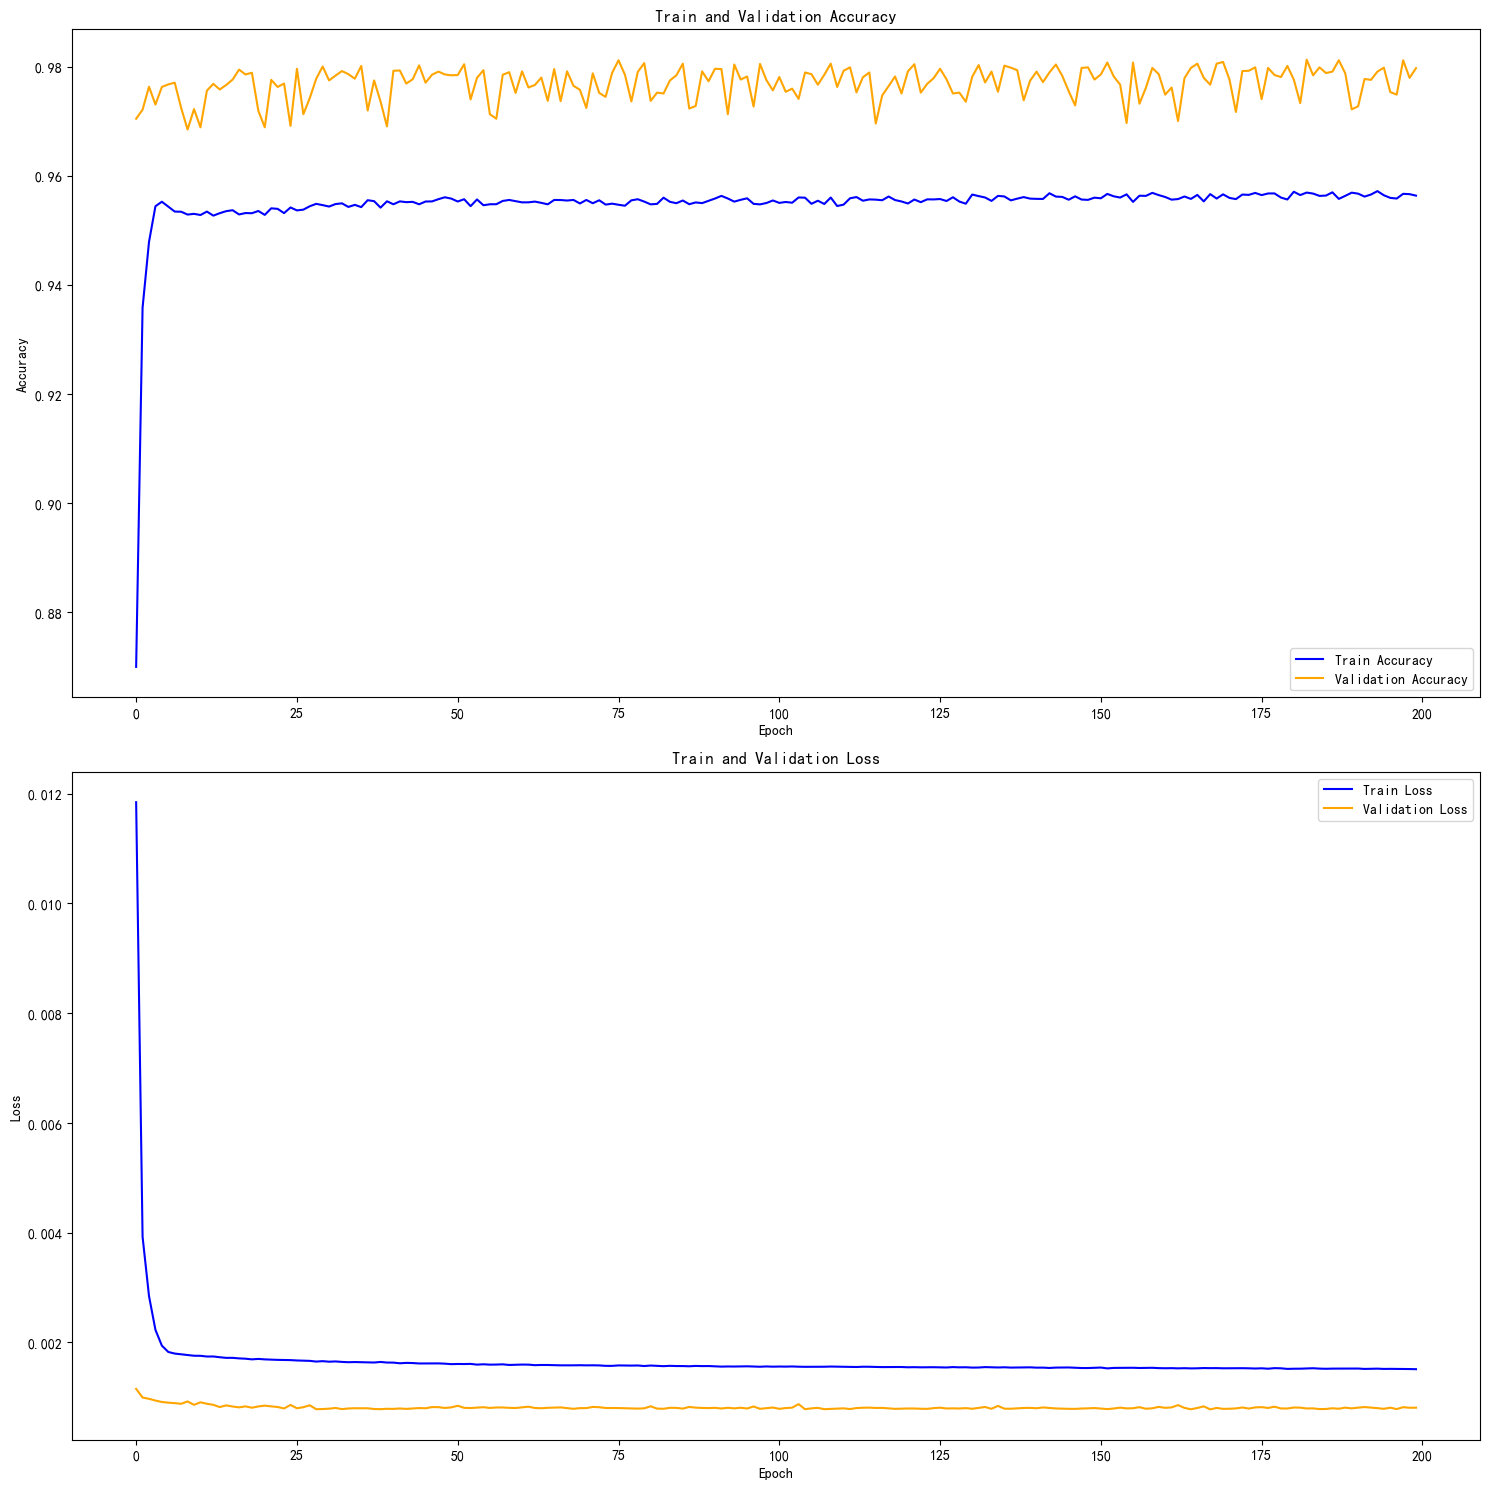

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.read_csv("./log_cnn_gru.csv")

fig, ax = plt.subplots(2, 1, figsize=(15, 15))

# Plot accuracy
ax[0].plot(logs['epoch'], logs['acc'], label='Train Accuracy', color='blue')
ax[0].plot(logs['epoch'], logs['val_acc'], label='Validation Accuracy', color='orange')
ax[0].set_title('Train and Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot loss
ax[1].plot(logs['epoch'], logs['loss'], label='Train Loss', color='blue')
ax[1].plot(logs['epoch'], logs['val_loss'], label='Validation Loss', color='orange')
ax[1].set_title('Train and Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()


In [8]:
from keras.models import load_model
import numpy as np

# 加载训练好的模型
model = load_model('cnn_gru_model.h5')

test_points_ids = list(set(test['MMSI']))
BP_error_list = []
BP_Pre0 = []
BP_Pre1 = []
BP_Pre2 = []
BP_Pre3 = []
BP_Tre0 = []
BP_Tre1 = []
BP_Tre2 = []
BP_Tre3 = []
for ids in test_points_ids:
    test_seq, test_label = createSequence(test.loc[test.MMSI == ids], windows, maxmin)
    # 要预测的时间
    pre_time = 10
    # 单值预测
    y_pre_BP_50, y_pre_lstm_50, y_pre_GRU_50, y_pre_biLSTM_50, y_pre_bigru_50, y_pre_CNN_RGRU_Attention_50 = [], [], [], [], [], []
    y_true = []

#     for start_id in range(test_seq.shape[0]-int(pre_time)):
    start_id = 0
    pre_seq = test_seq[start_id]
        # 循环预测
    for i in range(int(pre_time)):
        y_hat_BP_50 =model.predict(pre_seq.reshape(1, windows, 4))
            # 其他模型的预测类似...

        y_pre_BP_50.append(y_hat_BP_50[0])
            # 将其他模型的预测结果也添加到相应的列表中...

        y_true.append(test_label[start_id+i])
        # 下一个数组，把预测的值作为预测序列的最后一个值，实现循环预测
        pre_seq = np.insert(pre_seq, pre_seq.shape[0], y_hat_BP_50, axis=0)[1:]
            
    y_pre_BP_50 = np.array(y_pre_BP_50, dtype='float64')
#         y_pre_lstm_50 = np.array(y_pre_lstm_50, dtype='float64')
#         y_pre_GRU_50 = np.array(y_pre_GRU_50, dtype='float64')
#         y_pre_biLSTM_50 = np.array(y_pre_biLSTM_50, dtype='float64')
#         y_pre_bigru_50 = np.array(y_pre_bigru_50, dtype='float64')
#         y_pre_CNN_RGRU_Attention_50 = np.array(y_pre_CNN_RGRU_Attention_50, dtype='float64')

    y_true = np.array(y_true, dtype='float64')
        # 对预测结果进行归一化处理
    f_y_pre_BP_50, f_y_true = FNormalizeMult(y_pre_BP_50, y_true, maxmin)
        # 对其他模型的预测结果也进行相同的处理
#         f_y_pre_lstm_50, f_y_true = FNormalizeMult(y_pre_lstm_50, y_true, maxmin)
#         f_y_pre_GRU_50, f_y_true = FNormalizeMult(y_pre_GRU_50, y_true, maxmin)
#         f_y_pre_biLSTM_50, f_y_true = FNormalizeMult(y_pre_biLSTM_50, y_true, maxmin)
#         f_y_pre_bigru_50, f_y_true = FNormalizeMult(y_pre_bigru_50, y_true, maxmin)
#         f_y_pre_CNN_RGRU_Attention_50, f_y_true = FNormalizeMult(y_pre_CNN_RGRU_Attention_50, y_true, maxmin)


    BP_Pre0.append(list(np.array(f_y_pre_BP_50)[:, 0]))
    BP_Pre1.append(list(np.array(f_y_pre_BP_50)[:, 1]))
    BP_Pre2.append(list(np.array(f_y_pre_BP_50)[:, 2]))
    BP_Pre3.append(list(np.array(f_y_pre_BP_50)[:, 3]))
    BP_Tre0.append(list(np.array(f_y_true)[:, 0]))
    BP_Tre1.append(list(np.array(f_y_true)[:, 1]))
    BP_Tre2.append(list(np.array(f_y_true)[:, 2]))
    BP_Tre3.append(list(np.array(f_y_true)[:, 3]))
    # 将结果添加到错误列表中
#     BP_error_list.append(list(np.array(y_pre_BP_50)[:, 4]))
    # 将其他模型的结果也添加到相应的列表中...


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


In [9]:
BPP0_data = [item for sublist in BP_Pre0 for item in sublist]
# print(BPP0_data)
BPP1_data = [item for sublist in BP_Pre1 for item in sublist]
# print(BPP1_data)
BPP2_data = [item for sublist in BP_Pre2 for item in sublist]
# print(BPP2_data)
BPP3_data = [item for sublist in BP_Pre3 for item in sublist]
# print(BPP3_data)
BPT0_data = [item for sublist in BP_Tre0 for item in sublist]
# print(BPT0_data)
BPT1_data = [item for sublist in BP_Tre1 for item in sublist]
# print(BPT1_data)
BPT2_data = [item for sublist in BP_Tre2 for item in sublist]
# print(BPT2_data)
BPT3_data = [item for sublist in BP_Tre3 for item in sublist]
# print(BPT3_data)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(BPT0_data, BPP0_data)
print(f"平均绝对误差（MAE）: {mae}")
mse = mean_squared_error(BPT0_data, BPP0_data)
print(f"均方根误差（MSE）: {mse}")
rmse = np.sqrt(mse)
print(f"均方根误差（RMSE）: {rmse}")
r2 = r2_score(BPT0_data, BPP0_data)
print(f"R2分数（R2_score）: {r2}")
print("--------------------------------------------------")
mae = mean_absolute_error(BPT1_data, BPP1_data)
print(f"平均绝对误差（MAE）: {mae}")
mse = mean_squared_error(BPT1_data, BPP1_data)
print(f"均方根误差（MSE）: {mse}")
rmse = np.sqrt(mse)
print(f"均方根误差（RMSE）: {rmse}")
r2 = r2_score(BPT1_data, BPP1_data)
print(f"R2分数（R2_score）: {r2}")
print("--------------------------------------------------")
mae = mean_absolute_error(BPT2_data, BPP2_data)
print(f"平均绝对误差（MAE）: {mae}")
mse = mean_squared_error(BPT2_data, BPP2_data)
print(f"均方根误差（MSE）: {mse}")
rmse = np.sqrt(mse)
print(f"均方根误差（RMSE）: {rmse}")
r2 = r2_score(BPT2_data, BPP2_data)
print(f"R2分数（R2_score）: {r2}")
print("--------------------------------------------------")
mae = mean_absolute_error(BPT3_data, BPP3_data)
print(f"平均绝对误差（MAE）: {mae}")
mse = mean_squared_error(BPT3_data, BPP3_data)
print(f"均方根误差（MSE）: {mse}")
rmse = np.sqrt(mse)
print(f"均方根误差（RMSE）: {rmse}")
r2 = r2_score(BPT3_data, BPP3_data)
print(f"R2分数（R2_score）: {r2}")
print("--------------------------------------------------")

平均绝对误差（MAE）: 0.07395737745966613
均方根误差（MSE）: 0.008960427174950053
均方根误差（RMSE）: 0.09465953293224118
R2分数（R2_score）: 0.9889373994339232
--------------------------------------------------
平均绝对误差（MAE）: 0.06918529832356622
均方根误差（MSE）: 0.009479754540709878
均方根误差（RMSE）: 0.09736403104180659
R2分数（R2_score）: 0.9876552265571397
--------------------------------------------------
平均绝对误差（MAE）: 1.012772371086361
均方根误差（MSE）: 2.1355976220323605
均方根误差（RMSE）: 1.4613684073608408
R2分数（R2_score）: 0.6627224468401758
--------------------------------------------------
平均绝对误差（MAE）: 24.516916893667496
均方根误差（MSE）: 2436.9118189205137
均方根误差（RMSE）: 49.36508704459573
R2分数（R2_score）: 0.7582550005482223
--------------------------------------------------
